## Imports

In [1]:
import pandas as pd
import torch
import torch
import torch.nn as nn
from torchvision import models
import os
from utils import process_video_frames_tchw, count_predictions
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

#### Directory Setup

In [3]:
# Root directory for dataset
ROOT_DIR = '../../data/RepCount'
VIDEO_DIR = os.path.join(ROOT_DIR, 'video', 'test')

# Checkpoint path
CHECKPOINT_DIR = './'
TEST_ANNOTATION = os.path.join('./', 'test.csv')
ACTION_ANNOTATION = './all_action.csv'

#### Action Trigger Module Settings

In [4]:
ENTER_THRESHOLD = 0.78
EXIT_THRESHOLD = 0.4
MOMENTUM = 0.4

BATCH_SIZE = 64

#### Model initialization

In [5]:
# Initialize model and optimizer
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 16)
model = model.to(device)

/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'best_resnet50_v2.pth')
model.load_state_dict(torch.load(checkpoint_path))

df = pd.read_csv(TEST_ANNOTATION)

/tmp/ipykernel_838385/1884274383.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


In [7]:
df['type'].unique()

array(['situp', 'push_up', 'pull_up', 'bench_pressing', 'jump_jack',
       'squat', 'front_raise', 'pommelhorse'], dtype=object)

In [8]:
sigmoid = nn.Sigmoid()
actions = pd.read_csv(ACTION_ANNOTATION)
action_mapping = dict(zip(actions['action'], actions['label']))
action_mapping

{'pommelhorse': 0,
 'bench_pressing': 1,
 'pull_up': 2,
 'jump_jack': 3,
 'situp': 4,
 'front_raise': 5,
 'squat': 6,
 'push_up': 7}

### Helper Function

In [15]:
def predict_video(row):
    """Returns prediction, mae, and obo"""
    video_path = os.path.join(VIDEO_DIR, row['name'])
    action_type = row['type']
    ground_truth = row['count']
    transformed_tchw_tensor = process_video_frames_tchw(video_path).to(device)
    batch_size = 1

    Y = []

    model.eval() 
    with torch.no_grad(): 
        for i in range(0, len(transformed_tchw_tensor)+1, batch_size):
            batch = transformed_tchw_tensor[i:i+batch_size].cuda() 
            if batch.size(0) == 0:  # Check if the batch is empty
                continue
            output = model(batch)
            idx = action_mapping[action_type]
            y_hat = output.cpu().numpy()[0][idx:idx+2]
            confidences = sigmoid(torch.tensor(y_hat))
            Y.append(confidences[1]) 

    plt.plot(Y)

    return count_predictions(Y,
                             ground_truth,
                             ENTER_THRESHOLD,
                             EXIT_THRESHOLD,
                             MOMENTUM)

(1, 0.8333333331944445, 0)


Unnamed: 0              1
type              push_up
name          stu8_42.mp4
count                   6
L1                    0.0
                 ...     
L298                  NaN
L299                  NaN
L300                  NaN
L301                  NaN
L302                  NaN
Name: 1, Length: 306, dtype: object

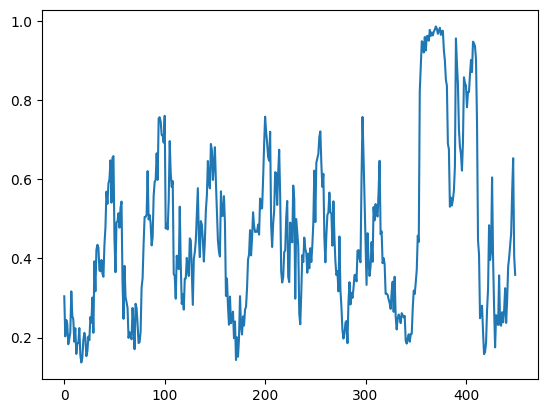

In [16]:
row = df.iloc[1]

print(predict_video(row))
row


### Cross Validation

In [11]:
oboas = []
maes = []

checkpoint_path = os.path.join(CHECKPOINT_DIR, 'best_resnet50_v2.pth')
model.load_state_dict(torch.load(checkpoint_path))

df = pd.read_csv(TEST_ANNOTATION)
df[['prediction', 'mae', 'obo']] = df.apply(lambda row: pd.Series(predict_video(row)), axis=1)
oboas.append(df['obo'].mean())
maes.append(df['mae'].mean())

save_file = os.path.join(CHECKPOINT_DIR, f'results_repcount_cowbytes.csv')
df.to_csv(save_file, index=False)

/tmp/ipykernel_320965/1818198556.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


### Results

In [12]:
oboas

[0.19205298013245034]

In [13]:
maes

[0.7094458741466838]

In [14]:
df['obo'].mean()

0.19205298013245034

TODO:
1. Probably try weighted
2. Try density maps
3. Tune the action trigger module